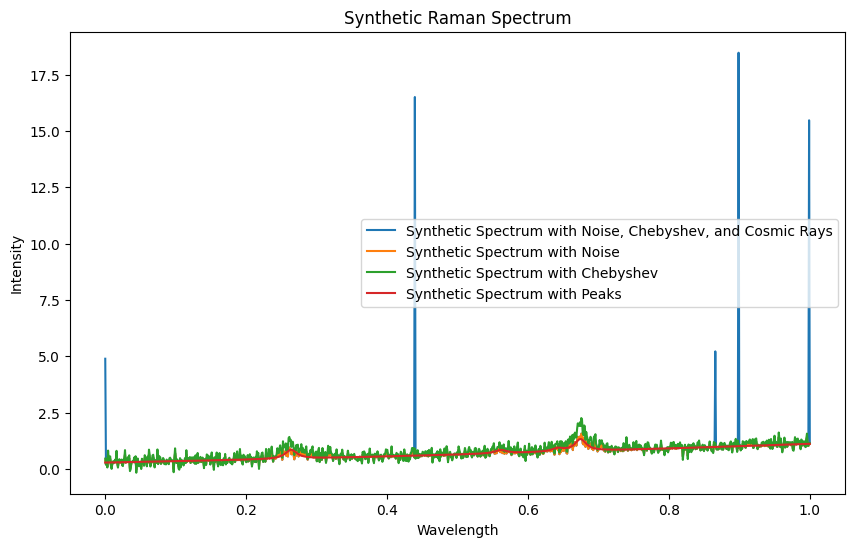

In [1]:
# All input modifications
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(0, 1, self.pixels)
        self.generate_spectrum()

    # Generate baseline using a polynomial
    def generate_spectrum(self):
        poly_order = np.random.randint(self.poly_order_range[0], self.poly_order_range[1] + 1)
        baseline_coefficients = np.random.rand(poly_order + 1)
        self.baseline = np.polyval(baseline_coefficients, self.wavelengths)
        
        # Generate Lorentzian peaks
        self.peaks = np.zeros_like(self.wavelengths)
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        for _ in range(num_peaks):
            peak_amplitude = np.random.uniform(0, 1)
            peak_position = np.random.uniform(0.2, 0.8)
            peak_width = 1 / (self.pixels * 0.1)
            self.peaks += peak_amplitude * (peak_width ** 2) / ((self.wavelengths - peak_position) ** 2 + peak_width ** 2)
          
        # Add peaks to signal
        self.peaky_spectrum = self.baseline + self.peaks
    
    # Generate Gaussian noise
    def add_gaussian_noise(self, noise_amplitude_range=(0.1, 0.5)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        noise *= noise_amplitudes

        # Add noise to baseline & peaks
        self.noisy_baseline = self.baseline + noise
        self.noisy_peaks = self.peaks + noise
        self.noisy_spectrum = self.noisy_baseline + self.noisy_peaks      

    # Generate Baseline variation
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
        
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(x))
         
        return chebyshev_vals

    def add_chebyshev_variation(self, num_iterations, min_order, max_order):
        # Randomly select polynomial order (for iteration)
        order = np.random.randint(min_order, max_order)

        # Initial guess for Chebyshev polynomial coefficients (randomly initialized)
        initial_guess = [np.random.uniform(-1, 1) for _ in range(order)]

        # Fit Chebyshev polynomial to noisy data (for iteration)
        popt, _ = curve_fit(self.chebyshev_polynomial, self.wavelengths, self.noisy_peaks, p0=initial_guess)

        # Generate baseline using fitted coefficients
        baseline = self.chebyshev_polynomial(self.wavelengths, *popt)

        # Add Chebyshev to noise, baseline & peaks
        chebyshev_baseline = self.noisy_baseline + baseline
        chebyshev_peaks = self.noisy_peaks + baseline
        chebyshev_noise = self.noisy_peaks + baseline

        # Add noise to chebyshev variation
        self.chebyshev_spectrum = self.noisy_spectrum + chebyshev_noise
    
    # Cosmic Rays
    def add_cosmic_rays(self, num_cosmic_rays):
        spectrum_with_cosmic_rays = self.noisy_spectrum.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(spectrum_with_cosmic_rays)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & l2_norm
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(spectrum_with_cosmic_rays))
        
            # Add cosmic ray as Lorentzian peak with width zero
            spectrum_with_cosmic_rays[position] += cosmic_ray_amplitude

        return spectrum_with_cosmic_rays

# Parameters
pixels = 1000
poly_order_range = (1, 3)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 1

# Create synthetic spectrum
synthetic_spectrum = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Add Gaussian noise
synthetic_spectrum.add_gaussian_noise()

# Add Chebyshev variation
num_iterations = 10
min_order = 1
max_order = 5
synthetic_spectrum.add_chebyshev_variation(num_iterations, min_order, max_order)

# Add cosmic rays
num_cosmic_rays = 5
final_spectrum = synthetic_spectrum.add_cosmic_rays(num_cosmic_rays)

# Plot spectra
plt.figure(figsize=(10, 6))
plt.plot(synthetic_spectrum.wavelengths, final_spectrum, label='Synthetic Spectrum with Noise, Chebyshev, and Cosmic Rays')
plt.plot(synthetic_spectrum.wavelengths, synthetic_spectrum.noisy_spectrum, label='Synthetic Spectrum with Noise')
plt.plot(synthetic_spectrum.wavelengths, synthetic_spectrum.chebyshev_spectrum, label='Synthetic Spectrum with Chebyshev')
plt.plot(synthetic_spectrum.wavelengths, synthetic_spectrum.peaky_spectrum, label='Synthetic Spectrum with Peaks')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Synthetic Raman Spectrum')
plt.show()